In [1]:
import os
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location
from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Global seed set to 0


## Loading Visium data 

In [2]:
adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

# rename genes to ENSEMBL
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var_names = adata_vis.var['gene_ids']
adata_vis.var_names.name = None

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

## Loading scRNA-seq reference data 

In [4]:
# Download data if not already here
if not os.path.exists('./data/sc.h5ad'):
    !cd ./data/ && wget https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad --no-check-certificate

# Read data
adata_ref = sc.read(f'data/sc.h5ad')

# Use ENSEMBL as gene IDs to make sure IDs are unique and correctly matched
adata_ref.var['SYMBOL'] = adata_ref.var.index
adata_ref.var.index = adata_ref.var['GeneID-2'].copy()
adata_ref.var_names = adata_ref.var['GeneID-2'].copy()
adata_ref.var.index.name = None
adata_ref.raw.var['SYMBOL'] = adata_ref.raw.var.index
adata_ref.raw.var.index = adata_ref.raw.var['GeneID-2'].copy()
adata_ref.raw.var.index.name = None

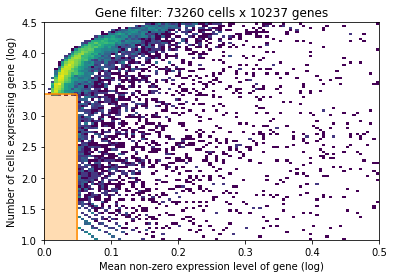

In [5]:
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
adata_ref = adata_ref[:, selected].copy()

## Coarser cell type labeling

In [6]:
cell_type_mapping = {
    'B_Cycling': 'B cells', 
    'B_GC_DZ': 'B cells',
    'B_GC_LZ': 'B cells', 
    'B_GC_prePB': 'B cells', 
    'B_IFN': 'B cells',
    'B_activated': 'B cells', 
    'B_mem': 'B cells', 
    'B_naive': 'B cells', 
    'B_plasma': 'B cells', 
    'B_preGC': 'B cells',
    'DC_CCR7+': 'DC', 
    'DC_cDC1': 'DC', 
    'DC_cDC2': 'DC', 
    'DC_pDC': 'DC', 
    'Endo': 'Endo', 
    'FDC': 'FDC', 
    'ILC': 'ILC',
    'Macrophages_M1': 'Macrophages', 
    'Macrophages_M2': 'Macrophages', 
    'Mast': 'Mast', 
    'Monocytes': 'Monocytes', 
    'NK': 'NK',
    'NKT': 'NKT', 
    'T_CD4+': 'CD4 T cells', 
    'T_CD4+_TfH': 'CD4 T cells', 
    'T_CD4+_TfH_GC': 'CD4 T cells', 
    'T_CD4+_naive': 'CD4 T cells',
    'T_CD8+_CD161+': 'CD8 T cells', 
    'T_CD8+_cytotoxic': 'CD8 T cells',
    'T_CD8+_naive': 'CD8 T cells', 
    'T_TIM3+': 'T TIM',
    'T_TfR': 'T TfR',
    'T_Treg': 'T Treg', 
    'VSMC': 'VSMC'
}
adata_ref.obs['ncem_cluster'] = list(
    adata_ref.obs['Subset'].values.map(cell_type_mapping).values
)

/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'ncem_cluster' as categorical


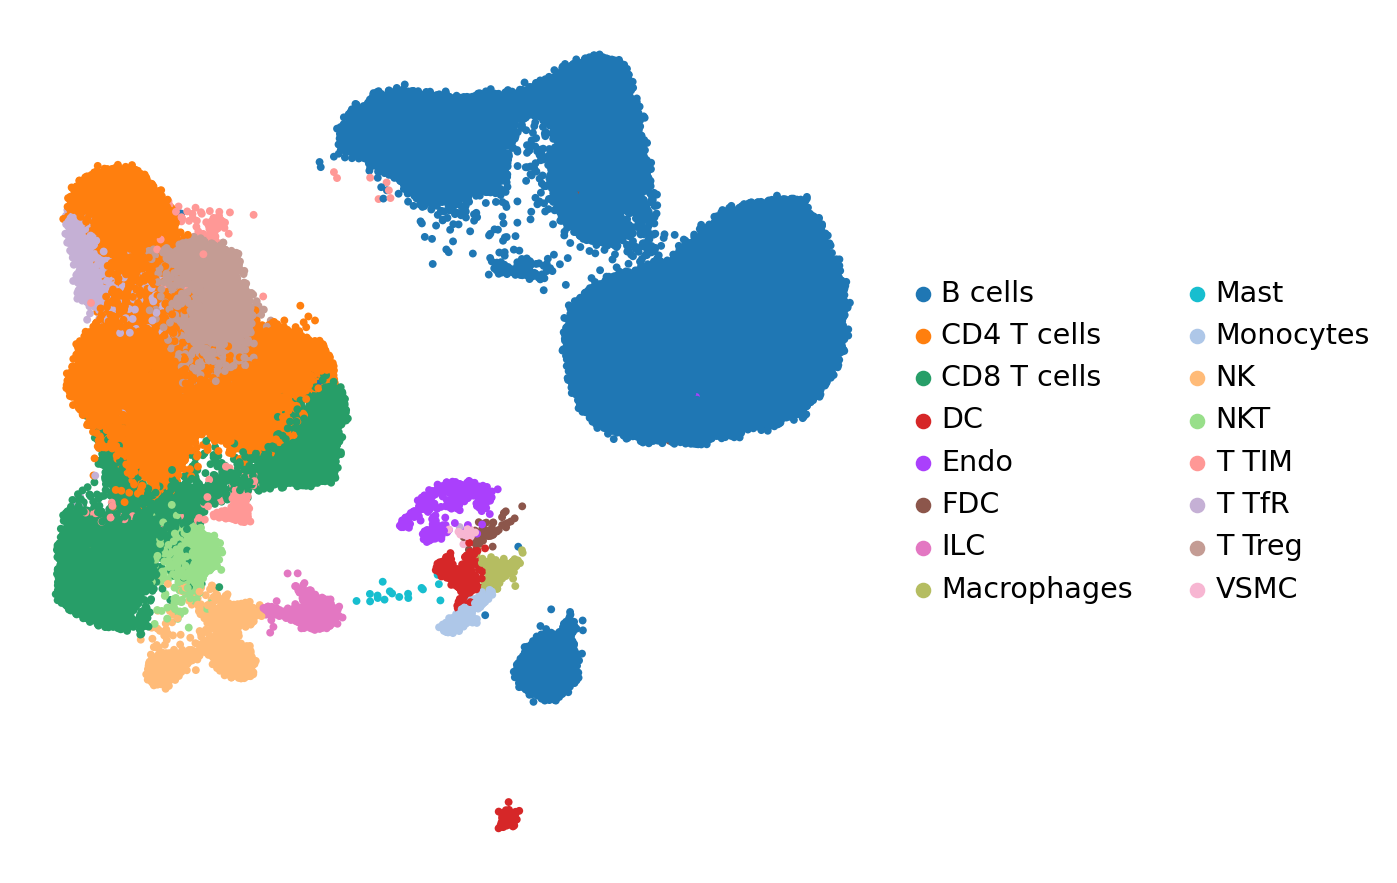

In [7]:
sc.set_figure_params(scanpy=True)
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(7,7),
)
sc.pl.umap(
    adata_ref, color='ncem_cluster', ax=ax, show=False, size=50,title="",
    frameon=False
)
plt.show()

## Estimation of reference cell type signatures (NB regression)

In [8]:
scvi.data.setup_anndata(
    adata=adata_ref,
    batch_key='Sample',
    labels_key='ncem_cluster',
    categorical_covariate_keys=['Method']
)

INFO     Using batches from adata.obs["Sample"]                                              
INFO     Using labels from adata.obs["ncem_cluster"]                                         
INFO     Using data from adata.X                                                             


/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 73260 cells, 10237 vars, 23       
         batches, 16 labels, and 0 proteins. Also registered 1 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [9]:
mod = RegressionModel(adata_ref)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|███████████████████████████████████████████████████████████████| 250/250 [14:00<00:00,  3.36s/it, v_num=1, elbo_train=2.96e+8]


In [10]:
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████| 999/999 [00:20<00:00, 48.00it/s]


In [11]:
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']

## Cell2location: spatial mapping

In [12]:
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
scvi.data.setup_anndata(adata=adata_vis, batch_key="sample")

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 4035 cells, 10217 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [ ]:
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    N_cells_per_location=30,
    detection_alpha=200
)
mod.train(
    max_epochs=30000, batch_size=None, train_size=1, use_gpu=True
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 18120/30000:  60%|█████████████████████████████████▏                     | 18119/30000 [33:15<12:37, 15.69it/s, v_num=1, elbo_train=4.56e+7]

In [ ]:
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

## Visualising cell abundance of B cells, CD4 T cells and CD8 T cells in spatial coordinates

In [ ]:
from cell2location.utils import select_slide
from cell2location.plt import plot_spatial

clust_labels = ['B cells','CD4 T cells', 'CD8 T cells']
clust_col = ['' + str(i) for i in clust_labels] 

slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        color=clust_col, labels=clust_labels,
        show_img=True,
        style='fast',
        max_color_quantile=0.992,
        circle_diameter=6,
        colorbar_position='right',
        reorder_cmap=[2,1,3,0,4,5,6]
    )

## Estimate cell-type specific expression of every gene in the spatial data

In [ ]:
expected_dict = mod.module.model.compute_expected_per_cell_type(
    adata_vis.uns['mod']['post_sample_q05'], mod.adata
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

In [ ]:
adata_vis

## Collect ncem anndata object

In [ ]:
cell_types = np.unique(list(cell_type_mapping.values()))
prop = adata_vis.obs[cell_types]

cell_expression = []
node_types = []
proportions = []
spatial = []
for i, ct in enumerate(cell_types):
    proportions.append(prop)
    cell_expression.append(adata_vis.layers[ct].toarray())
    nt = np.zeros((prop.shape[0], len(cell_types)))
    nt[:, i] = 1
    node_types.append(nt)
    spatial.append(adata_vis.obsm['spatial'])
    
proportions = pd.DataFrame(np.concatenate(proportions), columns=cell_types)
cell_expression = pd.DataFrame(np.concatenate(cell_expression), columns=adata_vis.var_names)
node_types = pd.DataFrame(np.concatenate(node_types), columns=cell_types)
spatial = pd.DataFrame(np.concatenate(spatial))

In [ ]:
from anndata import AnnData
ad = AnnData(cell_expression)
ad.obsm['proportions'] = np.array(proportions)
ad.obsm['node_types'] = np.array(node_types)
ad.obsm['spatial'] = np.array(spatial)

ad.uns["node_type_names"] = {x: x for x in cell_types}

In [ ]:
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=2000, subset=True,)

In [ ]:
ad

In [ ]:
path = ''
fn = 'cell2location_lymphnode.h5ad'
#ad.write(path + fn)